In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (
    Samplers,
    Policy,
    ema_logging,
    SequentialEvaluator,
    save_results
)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from SALib.analyze import sobol


Current working directory: /Users/florisvanamersfoort/Downloads/MBDM-main/final assignment
/Users/florisvanamersfoort/Downloads/EPA133a-Lab/.conda/bin/python


/Users/florisvanamersfoort/Downloads/EPA133a-Lab/.conda/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


----------------
### 1. SaLib

In [2]:
# Turn on logging
ema_logging.log_to_stderr(ema_logging.INFO)

# Policy formulation number 2 is chosen, as this is in line with the intrest of our client the Delta Commision
dike_model, planning_steps = get_model_for_problem_formulation(3)

In [3]:
# Define the model uncertainties
import copy
for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [4]:
# Define the model levers
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [5]:
# Printing the model outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Gelderland Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage'), function=<function sum_over at 0x162dbcd60>)
ScalarOutcome('Gelderland Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs'), function=<function sum_over at 0x162dbcd60>)
ScalarOutcome('Gelderland Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths'), function=<function sum_over at 0x162dbcd60>)
ScalarOutcome('Overijssel Expected Annual Damage', variable_name=('A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x162dbcd60>)
ScalarOutcome('Overijssel Dike Investment Costs', variable_name=('A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x162dbcd60>)
ScalarOutcome('Overijssel Expected Number of 

In [6]:
# Define a dictionary with all levers set to zero
lever_settings = {lever.name: 0 for lever in levers}

# Define the policy with all levers set to zero (no release)
zero_policy = Policy("Zero Policy", **lever_settings)

In [7]:
n_exp = 1000 # Number of experiments

In [8]:
# Perform experiments with Sobol sampling, using the zero-policy
# Setting up 40000 scenarios to match M=1000 with 19 uncertainties (2k+2)M = 40*1000 = 40000
with SequentialEvaluator(dike_model) as evaluator:
    experiments, results = evaluator.perform_experiments(scenarios=n_exp, policies=[zero_policy],
                                                         uncertainty_sampling=Samplers.SOBOL)


/Users/florisvanamersfoort/Downloads/EPA133a-Lab/.conda/lib/python3.11/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 40000 scenarios * 1 policies * 1 model(s) = 40000 experiments
100%|██████████████████████████████████| 40000/40000 [3:45:35<00:00,  2.96it/s]
[MainProcess/INFO] experiments finished


In [12]:
# Save the results
save_results((experiments, results), 'sequential_results.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/florisvanamersfoort/Downloads/MBDM-main/final assignment/sequential_results.tar.gz


In [13]:
# Print the experiments
problem = get_SALib_problem(uncertainties)
print(problem)

{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


---------
### 2. Visual Analysis

In [14]:
# Analyze using Sobol for Gelderland Expected Annual Damage
Si_Gel_Damage = sobol.analyze(problem, results['Gelderland Expected Annual Damage'], calc_second_order=True, print_to_console=True)
# Analyze using Sobol for Gelderland Dike Investment Costs
Si_Gel_Dike_Investment = sobol.analyze(problem, results['Gelderland Dike Investment Costs'], calc_second_order=True, print_to_console=True)
# Analyze using Sobol for Gelderland Expected Number of Deaths
Si_Gel_Deaths = sobol.analyze(problem, results['Gelderland Expected Number of Deaths'], calc_second_order=True, print_to_console=True)
# Analyze using Sobol for Overijssel Expected Annual Damage
Si_Over_Damage = sobol.analyze(problem, results['Overijssel Expected Annual Damage'], calc_second_order=True, print_to_console=True)
# Analyze using Sobol for Overijssel Dike Investment Costs
Si_Over_Dike_Investment = sobol.analyze(problem, results['Overijssel Dike Investment Costs'], calc_second_order=True, print_to_console=True)
# Analyze using Sobol for Overijssel Expected Number of Deaths
Si_Over_Deaths = sobol.analyze(problem, results['Overijssel Expected Number of Deaths'], calc_second_order=True, print_to_console=True)
# Analyze using Sobol for RfR Total Costs
Si_Rfr_Costs = sobol.analyze(problem, results['RfR Total Costs'], calc_second_order=True, print_to_console=True)
# Analyze using Sobol for Expected Evacuation Costs
Si_Evacuation_Costs = sobol.analyze(problem, results['Expected Evacuation Costs'], calc_second_order=True, print_to_console=True)


/Users/florisvanamersfoort/Downloads/EPA133a-Lab/.conda/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.004800  0.001038
A.1_Bmax                 0.012520  0.005374
A.1_Brate                0.000234  0.000188
A.1_pfail                0.724979  0.060088
A.2_Bmax                 0.000902  0.001620
A.2_Brate                0.000033  0.000066
A.2_pfail                0.028520  0.004362
A.3_Bmax                 0.000000  0.000000
A.3_Brate                0.000000  0.000000
A.3_pfail                0.261817  0.026695
A.4_Bmax                 0.000000  0.000000
A.4_Brate                0.000000  0.000000
A.4_pfail                0.000000  0.000000
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.000000  0.000000
discount rate 0          0.020059  0.002579
discount rate 1          0.020337  0.002260
discount rate 2          0.019459  0.002282
                               S1   S1_conf
A.0_ID flood wave shape  0.004112  0.006380
A.1_Bmax                 0.00298

/Users/florisvanamersfoort/Downloads/EPA133a-Lab/.conda/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/florisvanamersfoort/Downloads/EPA133a-Lab/.conda/lib/python3.11/site-packages/SALib/analyze/sobol.py:141: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A

/Users/florisvanamersfoort/Downloads/EPA133a-Lab/.conda/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.008343  0.001834
A.1_Bmax                 0.030246  0.011938
A.1_Brate                0.000560  0.000446
A.1_pfail                0.286810  0.030624
A.2_Bmax                 0.002070  0.003563
A.2_Brate                0.000072  0.000120
A.2_pfail                0.030593  0.007984
A.3_Bmax                 0.000000  0.000000
A.3_Brate                0.000000  0.000000
A.3_pfail                0.772930  0.070114
A.4_Bmax                 0.000000  0.000000
A.4_Brate                0.000000  0.000000
A.4_pfail                0.000000  0.000000
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.000000  0.000000
discount rate 0          0.000000  0.000000
discount rate 1          0.000000  0.000000
discount rate 2          0.000000  0.000000
                               S1   S1_conf
A.0_ID flood wave shape  0.000475  0.006998
A.1_Bmax                 0.00899

/Users/florisvanamersfoort/Downloads/EPA133a-Lab/.conda/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.026113  0.008963
A.1_Bmax                 0.034258  0.019872
A.1_Brate                0.001448  0.001290
A.1_pfail                0.362131  0.113860
A.2_Bmax                 0.006195  0.005251
A.2_Brate                0.000943  0.001543
A.2_pfail                0.141816  0.067942
A.3_Bmax                 0.007260  0.007097
A.3_Brate                0.000817  0.001269
A.3_pfail                0.254920  0.085510
A.4_Bmax                 0.000282  0.000469
A.4_Brate                0.000006  0.000013
A.4_pfail                0.054500  0.029965
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.855188  0.142007
discount rate 0          0.010712  0.003330
discount rate 1          0.007297  0.002523
discount rate 2          0.008444  0.002673
                               S1   S1_conf
A.0_ID flood wave shape  0.017786  0.018894
A.1_Bmax                 0.00637

/Users/florisvanamersfoort/Downloads/EPA133a-Lab/.conda/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/florisvanamersfoort/Downloads/EPA133a-Lab/.conda/lib/python3.11/site-packages/SALib/analyze/sobol.py:141: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A

/Users/florisvanamersfoort/Downloads/EPA133a-Lab/.conda/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.028890  0.010617
A.1_Bmax                 0.030317  0.019088
A.1_Brate                0.001483  0.001341
A.1_pfail                0.338386  0.110907
A.2_Bmax                 0.006320  0.006295
A.2_Brate                0.000789  0.001525
A.2_pfail                0.134951  0.057904
A.3_Bmax                 0.007092  0.006742
A.3_Brate                0.000803  0.001106
A.3_pfail                0.246229  0.087646
A.4_Bmax                 0.000263  0.000430
A.4_Brate                0.000009  0.000018
A.4_pfail                0.061158  0.039911
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.841648  0.152095
discount rate 0          0.000000  0.000000
discount rate 1          0.000000  0.000000
discount rate 2          0.000000  0.000000
                               S1   S1_conf
A.0_ID flood wave shape  0.020002  0.024983
A.1_Bmax                 0.00740

/Users/florisvanamersfoort/Downloads/EPA133a-Lab/.conda/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/florisvanamersfoort/Downloads/EPA133a-Lab/.conda/lib/python3.11/site-packages/SALib/analyze/sobol.py:141: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A

/Users/florisvanamersfoort/Downloads/EPA133a-Lab/.conda/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/florisvanamersfoort/Downloads/EPA133a-Lab/.conda/lib/python3.11/site-packages/SALib/analyze/sobol.py:141: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A

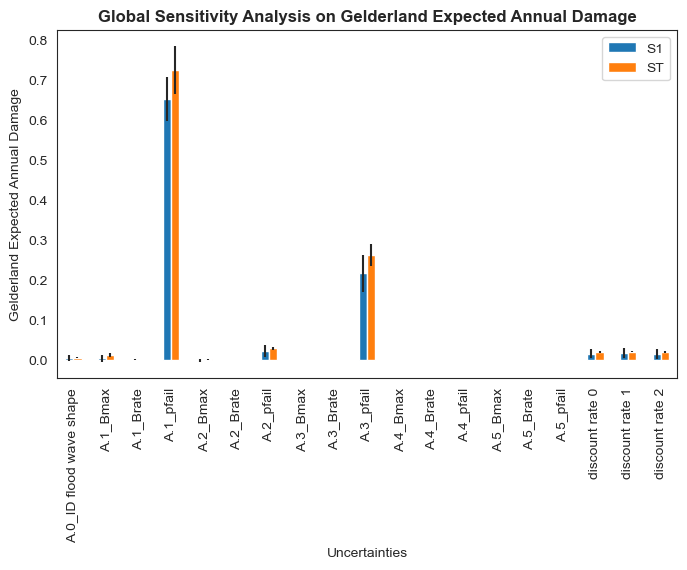

In [16]:
# Plot the results
Si_filter = {k:Si_Gel_Damage[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.title('Global Sensitivity Analysis on Gelderland Expected Annual Damage',fontweight='bold')
plt.xlabel('Uncertainties')
plt.ylabel('Gelderland Expected Annual Damage')
plt.show()

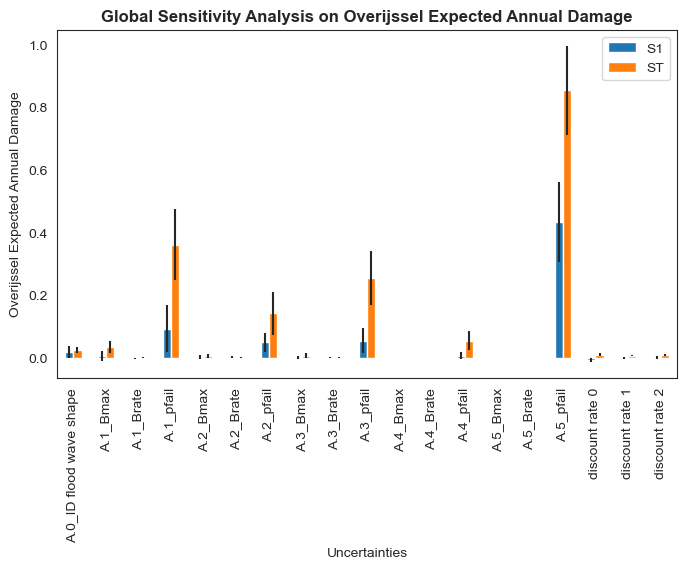

In [17]:
# Plot the results
Si_filter = {k:Si_Over_Damage[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.title('Global Sensitivity Analysis on Overijssel Expected Annual Damage',fontweight='bold')
plt.xlabel('Uncertainties')
plt.ylabel('Overijssel Expected Annual Damage')
plt.show()

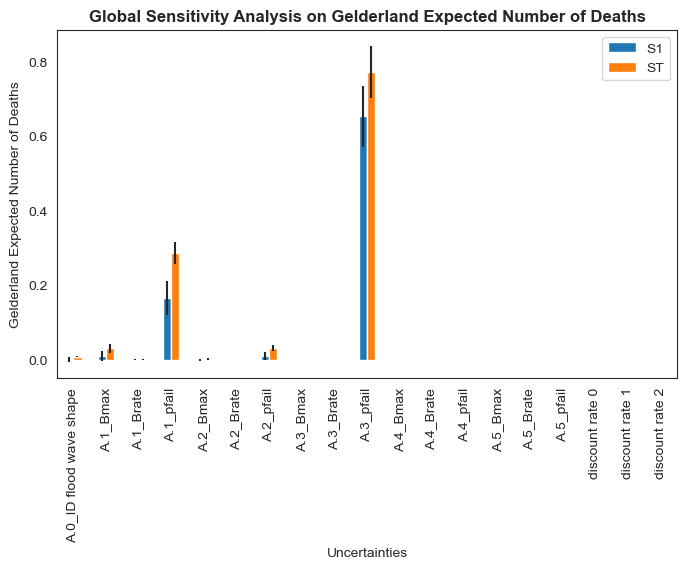

In [18]:
# Plot the results
Si_filter = {k:Si_Gel_Deaths[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.title('Global Sensitivity Analysis on Gelderland Expected Number of Deaths',fontweight='bold')
plt.xlabel('Uncertainties')
plt.ylabel('Gelderland Expected Number of Deaths')
plt.show()


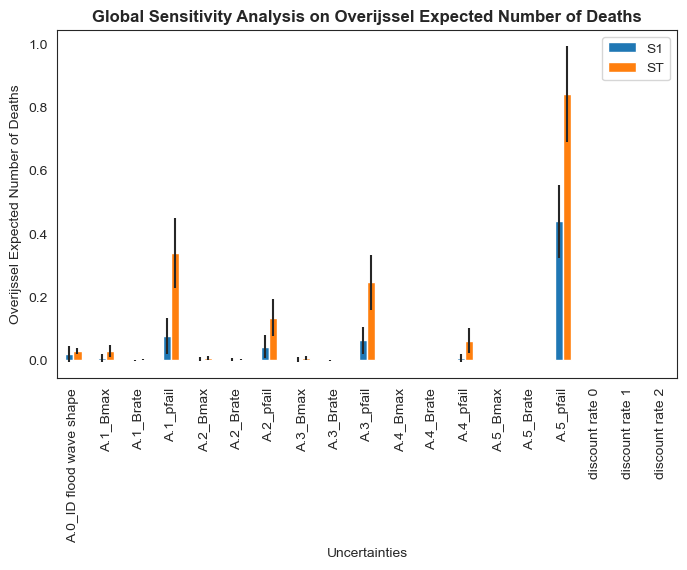

In [19]:
# Plot the results
Si_filter = {k:Si_Over_Deaths[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.title('Global Sensitivity Analysis on Overijssel Expected Number of Deaths',fontweight='bold')
plt.xlabel('Uncertainties')
plt.ylabel('Overijssel Expected Number of Deaths')
plt.show()